In [1]:
# Install yfinance (run this once)
!pip install yfinance

# 1. Essential Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ------------------------------------- 949.2/949.2 kB 12.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 16.6 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15618 sha256=40fa91c4df06c853dfc138c661e9a238017738b5a5cc9d25d3ba1f9b7538120a
  Stored in directory: c:\users\kapil\appdata\local\pip\cache\wheels\1e\df\0f\e2bbb22d689b30c681feb5410ab6

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
# Define the stock and time period
stock_ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2024-01-01' # Note: We use a fixed end date for consistent training

# Download the data using yfinance
df = yf.download(stock_ticker, start=start_date, end=end_date)

# Display the first 5 rows to check the data structure
print(df.head())

C:\Users\kapil\AppData\Local\Temp\ipykernel_10220\3979955768.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.424605  6.439315  6.375673  6.407194  493729600
2010-01-05  6.435713  6.472037  6.401790  6.442317  601904800
2010-01-06  6.333344  6.461230  6.326740  6.435713  552160000
2010-01-07  6.321636  6.364265  6.275705  6.356760  477131200
2010-01-08  6.363666  6.364266  6.276008  6.313232  447610800


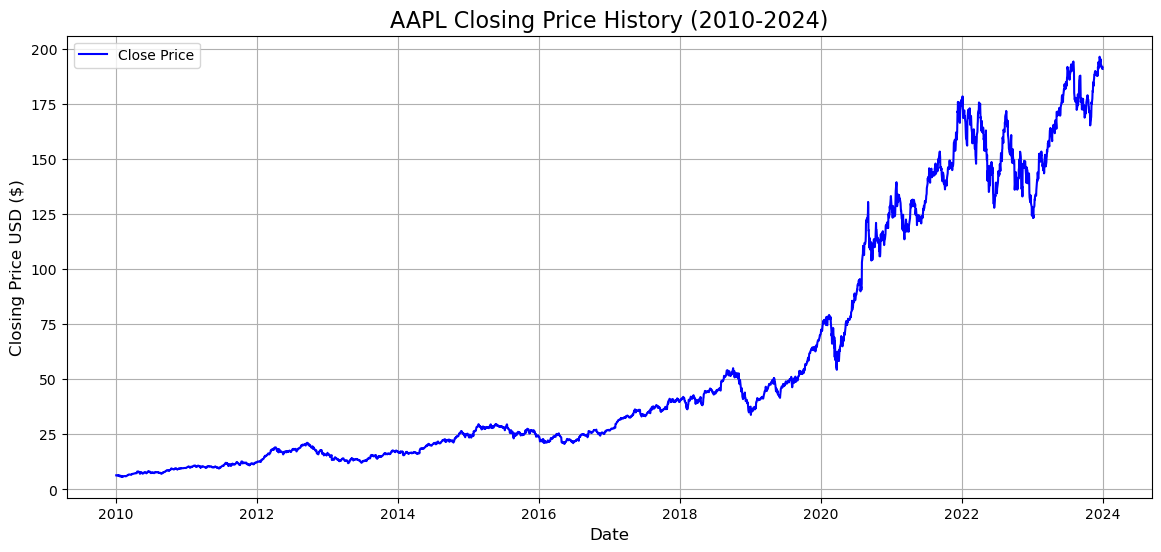

In [3]:
# Plotting the closing price history
plt.figure(figsize=(14, 6))
plt.title(f'{stock_ticker} Closing Price History (2010-2024)', fontsize=16)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price USD ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# 1. Filter: Get only the 'Close' price column (Pandas DataFrame slice)
data_close_df = df[['Close']]

# 2. Convert to NumPy array and ensure correct 2D shape (The Fix is here!)
# We use .values, which creates a NumPy array with shape (3522, 1)
data_close = data_close_df.values 

# 3. Scale: Normalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)

# 4. Split: Determine the split point (80% for training)
training_data_len = int(len(scaled_data) * 0.8)

# Create the training data set (80% of the scaled data)
train_data = scaled_data[0:training_data_len, :]

# Output check
print(f"Shape of data_close (must be X rows, 1 column): {data_close.shape}")
print(f"Total data points: {len(data_close)}")
print(f"Scaled data (first 5): {scaled_data[:5].flatten()}")
print(f"Training set size: {len(train_data)} days")

Shape of data_close (must be X rows, 1 column): (3522, 1)
Total data points: 3522
Scaled data (first 5): [0.0034573  0.00351555 0.00297869 0.00291729 0.00313771]
Training set size: 2817 days


In [6]:
# Re-run this entire cell (No change needed, just re-execution)
# Function to create sequences (e.g., 60 days of input to predict 1 day of output)
def create_sequences(data, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(data)):
        # X: contains the previous 'time_step' (60) values
        X.append(data[i-time_step:i, 0])
        # Y: contains the target value (the 61st day's price)
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

# Create the training features (X_train) and targets (y_train)
time_step = 60
X_train, y_train = create_sequences(train_data, time_step)

# Reshape data for the LSTM model
# LSTM expects input in the format: [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Final check of the shapes
print(f"X_train shape (samples, time_steps, features): {X_train.shape}")
print(f"y_train shape (targets): {y_train.shape}")


X_train shape (samples, time_steps, features): (2757, 60, 1)
y_train shape (targets): (2757,)


In [8]:
# Install TensorFlow in your current environment
!pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 3.7/332.0 MB 20.5 MB/s eta 0:00:17
   ---------------------------------------- 3.7/332.0 MB 20.5 MB/s eta 0:00:17
    --------------------------------------- 5.5/332.0 MB 9.2 MB/s eta 0:00:36
    --------------------------------------- 6.3/332.0 MB 7.3 MB/s eta 0:00:45
    --------------------------------------- 6.6/332.0 MB 6.9 MB/s eta 0:00:48
    --------------------------------------- 7.3/332.0 MB 5.8 MB/s eta 0:00:57
   - ---------------------------

In [9]:
# Import TensorFlow/Keras components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Initialize the Sequential model
model = Sequential()

# 2. Add the first LSTM layer
# 50 units, returns sequences for the next LSTM layer, 
# and defines the input shape based on our X_train data (60 timesteps, 1 feature)
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Prevents overfitting

# 3. Add the second LSTM layer

# 50 units, but does NOT return sequences (since this is the last LSTM layer)
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2)) # Prevents overfitting

# 4. Add the final Dense layer (Output Layer)
# 1 neuron because we are predicting a single value (the next day's price)
model.add(Dense(1))

# 5. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model structure
print(model.summary())

C:\Users\kapil\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# Train the model
# X_train is the input (60-day sequences), y_train is the target (61st day price)
history = model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=25, # Let it run for 25 epochs
    verbose=1 # Shows training progress
)

Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 0.0029
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 5.2742e-04
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 4.9952e-04
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 4.5430e-04
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 4.0063e-04
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 3.8936e-04
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 3.5043e-04
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 3.2538e-04
Epoch 9/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 3.1956e-04
Epoch 10/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.6594e-04
Epoch 11/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 3.2238e-04
Epoch 12/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 2.8712e-04
Epoch 13/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 2.7270e-04
Epoch 14/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 3.2019e-04
Epoch 15/25
87/

In [11]:
# 1. Prepare the Test Data Array
# We need the scaled data starting 60 days BEFORE the test period began
# This is because the model needs the last 60 days of the training set to make the very first prediction in the test set.

# Recall: scaled_data was created in Cell 4
test_start_index = training_data_len - 60
test_data = scaled_data[test_start_index:, :]

# 2. Create the X_test and y_test sets
# We use the same sequence function, but this time on the test_data
X_test, y_test = create_sequences(test_data, time_step)

# 3. Reshape the data for the LSTM model (must match training shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (705, 60, 1)
y_test shape: (705,)


In [12]:
# 1. Generate the predicted scaled prices
predictions_scaled = model.predict(X_test)

# 2. Inverse Transform: Convert the scaled predictions back to actual dollar prices
predictions = scaler.inverse_transform(predictions_scaled)

# 3. Inverse Transform: Convert the actual scaled test prices (y_test) back to dollar prices
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Display the first few actual vs. predicted prices
print("\nFirst 5 Actual Prices (USD):", y_test_unscaled[:5].flatten())
print("First 5 Predicted Prices (USD):", predictions[:5].flatten())

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step  

First 5 Actual Prices (USD): [120.99589539 122.53774261 121.74729919 117.61943054 117.09248352]
First 5 Predicted Prices (USD): [118.47362  118.80661  119.47134  120.16336  120.360596]


In [13]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE (Root Mean Squared Error)
# This measures the average deviation (in dollars) of your predictions from the actual price.
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))

print(f"Root Mean Squared Error (RMSE) for Test Data: ${rmse:.2f}")

Root Mean Squared Error (RMSE) for Test Data: $4.49


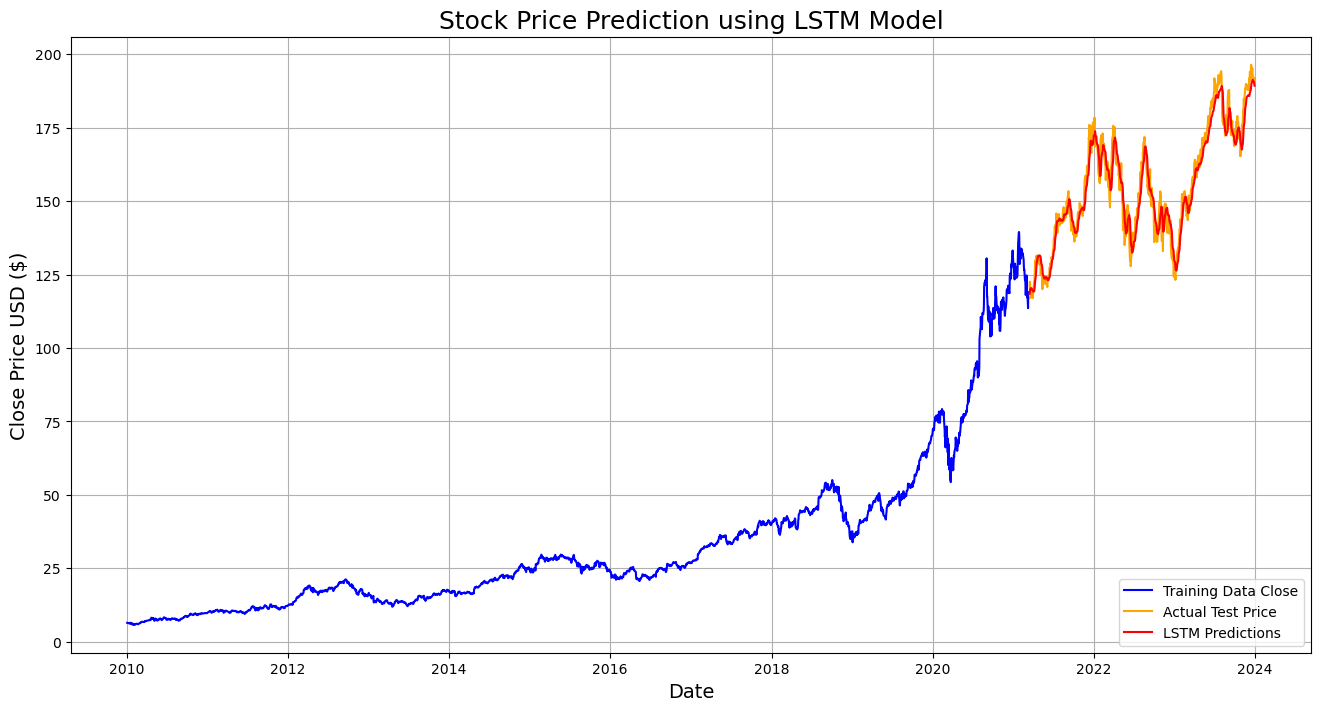

In [14]:
# Create DataFrame for plotting
# The training data is the first 80%
train = df[:training_data_len]

# The validation/test data starts where the training data ended
valid = df[training_data_len:].copy() 

# Add the predictions to the valid DataFrame
# Note: The predictions array has a length of 705 (X_test.shape[0]), 
# so we match it up with the last 705 days of the test period.
valid['Predictions'] = predictions 

# Plot the data
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction using LSTM Model', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

# Plot Training Data (Blue)
plt.plot(train['Close'], label='Training Data Close', color='blue')

# Plot Actual Test Data (Orange) and Predictions (Red) on the test period
plt.plot(valid['Close'], label='Actual Test Price', color='orange')
plt.plot(valid['Predictions'], label='LSTM Predictions', color='red')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()